In [32]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [33]:
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 10
REAL_LABEL = 1
FAKE_LABEL = 0
lr_d = 0.0002
lr_g = 0.0002

In [34]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [35]:
dataset = torchvision.datasets.MNIST(
    root=DATA_PATH,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((X_DIM, X_DIM)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

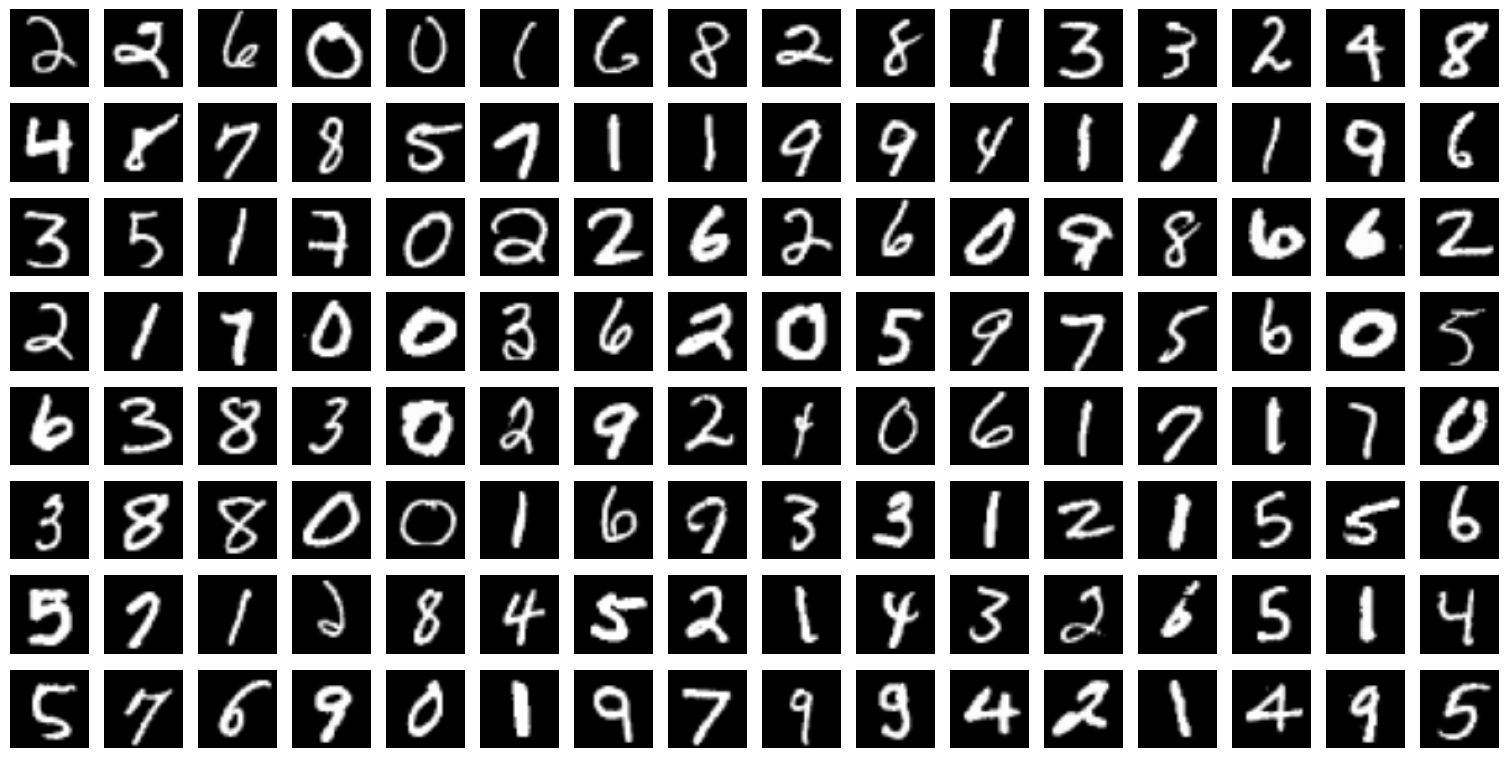

In [36]:
def plot_images(images, vmin=0, vmax=255, columns=6, width=2, height=2):
    rows = -(-len(images) // columns)
    plt.figure(figsize=(columns * width, rows * height)) 
    cmap = 'gray' if (images.ndim == 3 or images.shape[-1] == 1) else None
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap)
        plt.axis(False)
    plt.show()

real_batch = next(iter(dataloader))[0].reshape(-1, X_DIM, X_DIM, 1)
plot_images(real_batch, vmin=-1, vmax=1, columns=16, height=1.2, width=1.2)

In [37]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0., 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [38]:
from torch import nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)
        

In [39]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

In [40]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [41]:
criterion = nn.BCELoss()
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(0.5, 0.999))

[0/10][0/469]	Loss_D: 2.0735	Loss_G: 2.3023	D(x): 0.3038	D(G(z)): 0.4388 / 0.1298


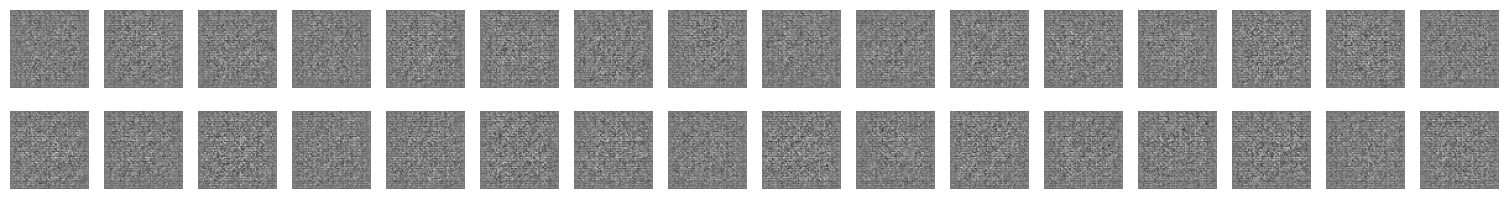

[0/10][50/469]	Loss_D: 1.5766	Loss_G: 24.7164	D(x): 0.4747	D(G(z)): 0.0000 / 0.0000
[0/10][100/469]	Loss_D: 0.1409	Loss_G: 4.9120	D(x): 0.9500	D(G(z)): 0.0728 / 0.0096
[0/10][150/469]	Loss_D: 0.4713	Loss_G: 7.2994	D(x): 0.9394	D(G(z)): 0.2793 / 0.0016
[0/10][200/469]	Loss_D: 0.1878	Loss_G: 3.1969	D(x): 0.8861	D(G(z)): 0.0508 / 0.0546
[0/10][250/469]	Loss_D: 0.1029	Loss_G: 4.2395	D(x): 0.9673	D(G(z)): 0.0596 / 0.0240
[0/10][300/469]	Loss_D: 0.5012	Loss_G: 3.8759	D(x): 0.8477	D(G(z)): 0.2506 / 0.0306
[0/10][350/469]	Loss_D: 0.2152	Loss_G: 2.9025	D(x): 0.8557	D(G(z)): 0.0451 / 0.0835
[0/10][400/469]	Loss_D: 0.9539	Loss_G: 5.6255	D(x): 0.9710	D(G(z)): 0.4923 / 0.0091
[0/10][450/469]	Loss_D: 0.1807	Loss_G: 3.6557	D(x): 0.9409	D(G(z)): 0.1048 / 0.0377
[1/10][0/469]	Loss_D: 0.4063	Loss_G: 3.0676	D(x): 0.8313	D(G(z)): 0.1727 / 0.0714


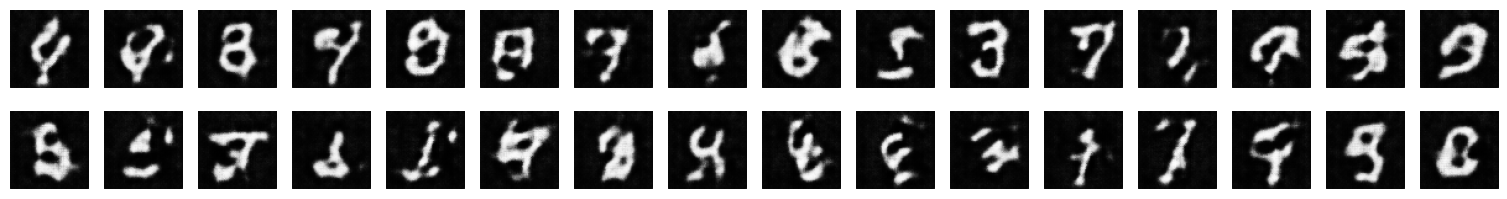

[1/10][50/469]	Loss_D: 0.3435	Loss_G: 2.0918	D(x): 0.8881	D(G(z)): 0.1657 / 0.1806
[1/10][100/469]	Loss_D: 0.3449	Loss_G: 2.4393	D(x): 0.8880	D(G(z)): 0.1849 / 0.1155
[1/10][150/469]	Loss_D: 0.3096	Loss_G: 2.6872	D(x): 0.8565	D(G(z)): 0.1251 / 0.0960
[1/10][200/469]	Loss_D: 3.0949	Loss_G: 0.0060	D(x): 0.0718	D(G(z)): 0.0249 / 0.9940
[1/10][250/469]	Loss_D: 0.3994	Loss_G: 2.2410	D(x): 0.7166	D(G(z)): 0.0315 / 0.1499
[1/10][300/469]	Loss_D: 0.3704	Loss_G: 2.3706	D(x): 0.9022	D(G(z)): 0.2126 / 0.1251
[1/10][350/469]	Loss_D: 0.8310	Loss_G: 2.2637	D(x): 0.7599	D(G(z)): 0.3694 / 0.1308
[1/10][400/469]	Loss_D: 0.2907	Loss_G: 2.9196	D(x): 0.9119	D(G(z)): 0.1667 / 0.0700
[1/10][450/469]	Loss_D: 0.9481	Loss_G: 1.0608	D(x): 0.4659	D(G(z)): 0.0749 / 0.4093
[2/10][0/469]	Loss_D: 0.4409	Loss_G: 2.1254	D(x): 0.7532	D(G(z)): 0.1222 / 0.1516
[2/10][50/469]	Loss_D: 0.6010	Loss_G: 1.5165	D(x): 0.6664	D(G(z)): 0.0978 / 0.2810


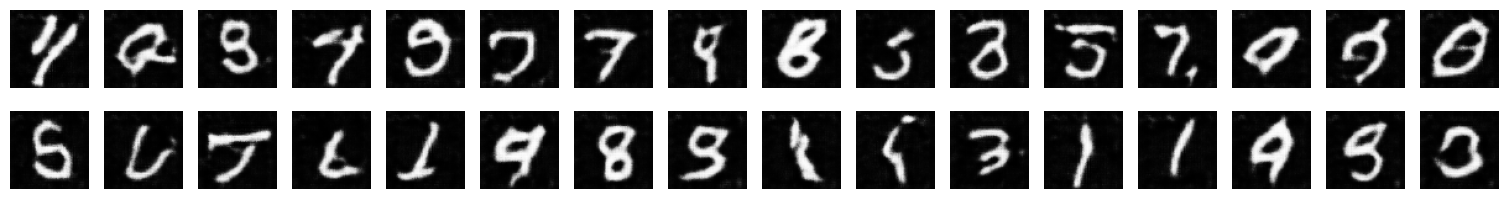

[2/10][100/469]	Loss_D: 0.9199	Loss_G: 3.6710	D(x): 0.6539	D(G(z)): 0.2020 / 0.0502
[2/10][150/469]	Loss_D: 0.4477	Loss_G: 2.1617	D(x): 0.8784	D(G(z)): 0.2332 / 0.1536
[2/10][200/469]	Loss_D: 1.6143	Loss_G: 8.0600	D(x): 0.9895	D(G(z)): 0.7048 / 0.0009
[2/10][250/469]	Loss_D: 2.1157	Loss_G: 5.4286	D(x): 0.9952	D(G(z)): 0.8274 / 0.0087
[2/10][300/469]	Loss_D: 0.1195	Loss_G: 3.5544	D(x): 0.9358	D(G(z)): 0.0464 / 0.0397
[2/10][350/469]	Loss_D: 0.4667	Loss_G: 3.2363	D(x): 0.8734	D(G(z)): 0.2522 / 0.0573
[2/10][400/469]	Loss_D: 1.5247	Loss_G: 4.5329	D(x): 0.9895	D(G(z)): 0.6905 / 0.0273
[2/10][450/469]	Loss_D: 0.7063	Loss_G: 2.3614	D(x): 0.8140	D(G(z)): 0.3445 / 0.1269
[3/10][0/469]	Loss_D: 0.6679	Loss_G: 2.1492	D(x): 0.5946	D(G(z)): 0.0228 / 0.1711
[3/10][50/469]	Loss_D: 0.1752	Loss_G: 3.7957	D(x): 0.8597	D(G(z)): 0.0102 / 0.0305


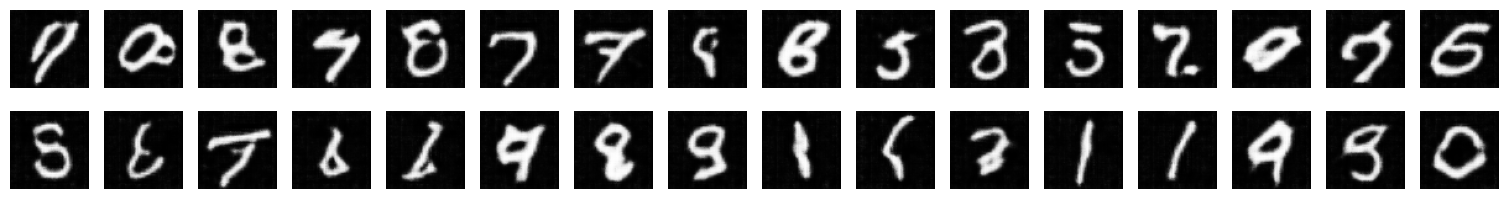

[3/10][100/469]	Loss_D: 3.2652	Loss_G: 5.3281	D(x): 0.8571	D(G(z)): 0.8693 / 0.0087
[3/10][150/469]	Loss_D: 1.7497	Loss_G: 5.8188	D(x): 0.9947	D(G(z)): 0.7600 / 0.0049
[3/10][200/469]	Loss_D: 0.2173	Loss_G: 3.4175	D(x): 0.9304	D(G(z)): 0.1249 / 0.0479
[3/10][250/469]	Loss_D: 0.7729	Loss_G: 4.6873	D(x): 0.9679	D(G(z)): 0.4614 / 0.0132
[3/10][300/469]	Loss_D: 0.1508	Loss_G: 3.2838	D(x): 0.9146	D(G(z)): 0.0537 / 0.0542
[3/10][350/469]	Loss_D: 0.0745	Loss_G: 3.9835	D(x): 0.9541	D(G(z)): 0.0251 / 0.0291
[3/10][400/469]	Loss_D: 0.2965	Loss_G: 3.0499	D(x): 0.9277	D(G(z)): 0.1808 / 0.0664
[3/10][450/469]	Loss_D: 0.3237	Loss_G: 6.3389	D(x): 0.9784	D(G(z)): 0.2388 / 0.0025
[4/10][0/469]	Loss_D: 0.7670	Loss_G: 1.4360	D(x): 0.5422	D(G(z)): 0.0355 / 0.3062
[4/10][50/469]	Loss_D: 0.0931	Loss_G: 3.9901	D(x): 0.9612	D(G(z)): 0.0494 / 0.0261
[4/10][100/469]	Loss_D: 0.4551	Loss_G: 2.0845	D(x): 0.7665	D(G(z)): 0.1401 / 0.1621


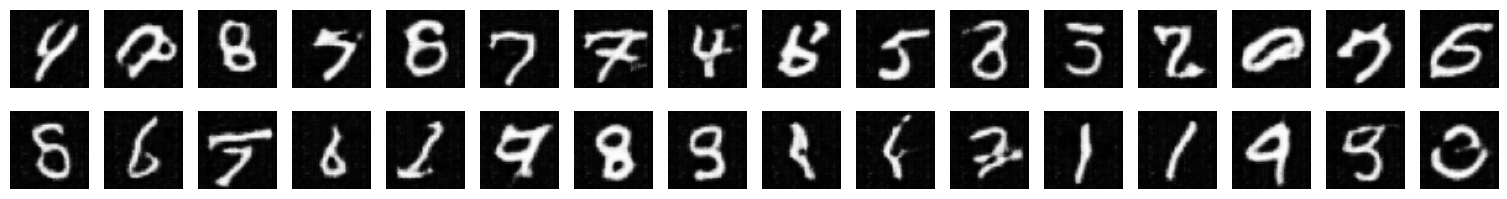

[4/10][150/469]	Loss_D: 0.9398	Loss_G: 7.3764	D(x): 0.9650	D(G(z)): 0.5361 / 0.0010
[4/10][200/469]	Loss_D: 0.0868	Loss_G: 4.3550	D(x): 0.9503	D(G(z)): 0.0329 / 0.0215
[4/10][250/469]	Loss_D: 0.0549	Loss_G: 4.3921	D(x): 0.9713	D(G(z)): 0.0245 / 0.0177
[4/10][300/469]	Loss_D: 0.6897	Loss_G: 2.6423	D(x): 0.8083	D(G(z)): 0.3306 / 0.0894
[4/10][350/469]	Loss_D: 0.4766	Loss_G: 4.1728	D(x): 0.9858	D(G(z)): 0.3299 / 0.0222
[4/10][400/469]	Loss_D: 0.3393	Loss_G: 3.0540	D(x): 0.9636	D(G(z)): 0.2332 / 0.0731
[4/10][450/469]	Loss_D: 0.1327	Loss_G: 4.1779	D(x): 0.9360	D(G(z)): 0.0602 / 0.0236
[5/10][0/469]	Loss_D: 0.0872	Loss_G: 3.8206	D(x): 0.9650	D(G(z)): 0.0478 / 0.0291
[5/10][50/469]	Loss_D: 0.9453	Loss_G: 1.1039	D(x): 0.5035	D(G(z)): 0.1302 / 0.3889
[5/10][100/469]	Loss_D: 1.4907	Loss_G: 0.7816	D(x): 0.2919	D(G(z)): 0.0075 / 0.5253
[5/10][150/469]	Loss_D: 1.3745	Loss_G: 2.5827	D(x): 0.8319	D(G(z)): 0.6074 / 0.1128


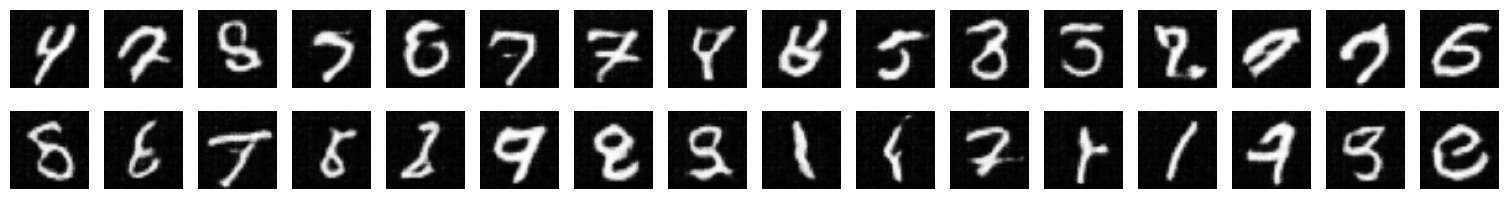

[5/10][200/469]	Loss_D: 0.1957	Loss_G: 3.9372	D(x): 0.9762	D(G(z)): 0.1488 / 0.0266
[5/10][250/469]	Loss_D: 0.2141	Loss_G: 3.8042	D(x): 0.9320	D(G(z)): 0.1205 / 0.0345
[5/10][300/469]	Loss_D: 0.5096	Loss_G: 2.8628	D(x): 0.6969	D(G(z)): 0.0967 / 0.0923
[5/10][350/469]	Loss_D: 0.0681	Loss_G: 4.0496	D(x): 0.9511	D(G(z)): 0.0162 / 0.0255
[5/10][400/469]	Loss_D: 0.6455	Loss_G: 1.9932	D(x): 0.7542	D(G(z)): 0.2798 / 0.1646
[5/10][450/469]	Loss_D: 0.2005	Loss_G: 4.0343	D(x): 0.9448	D(G(z)): 0.1204 / 0.0273
[6/10][0/469]	Loss_D: 0.6943	Loss_G: 1.2845	D(x): 0.6204	D(G(z)): 0.1268 / 0.3344
[6/10][50/469]	Loss_D: 0.5043	Loss_G: 2.1390	D(x): 0.7724	D(G(z)): 0.1789 / 0.1524
[6/10][100/469]	Loss_D: 0.9306	Loss_G: 1.0223	D(x): 0.5061	D(G(z)): 0.1275 / 0.4187
[6/10][150/469]	Loss_D: 0.0864	Loss_G: 4.1128	D(x): 0.9743	D(G(z)): 0.0564 / 0.0238


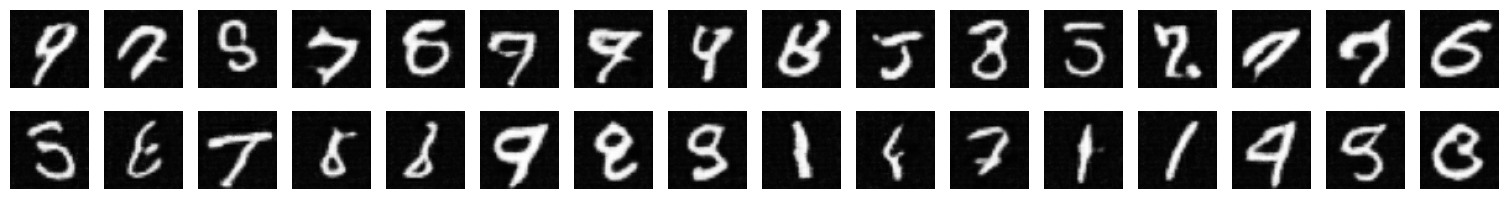

[6/10][200/469]	Loss_D: 0.0607	Loss_G: 4.0221	D(x): 0.9675	D(G(z)): 0.0263 / 0.0256
[6/10][250/469]	Loss_D: 0.5389	Loss_G: 2.4433	D(x): 0.7651	D(G(z)): 0.2010 / 0.1165
[6/10][300/469]	Loss_D: 0.4265	Loss_G: 2.5352	D(x): 0.7926	D(G(z)): 0.1481 / 0.1115
[6/10][350/469]	Loss_D: 0.9138	Loss_G: 1.0744	D(x): 0.4669	D(G(z)): 0.0065 / 0.4228
[6/10][400/469]	Loss_D: 0.4379	Loss_G: 4.0354	D(x): 0.9730	D(G(z)): 0.2863 / 0.0281
[6/10][450/469]	Loss_D: 0.3845	Loss_G: 2.5357	D(x): 0.7494	D(G(z)): 0.0516 / 0.1159
[7/10][0/469]	Loss_D: 0.1236	Loss_G: 4.0737	D(x): 0.9602	D(G(z)): 0.0756 / 0.0243
[7/10][50/469]	Loss_D: 0.0724	Loss_G: 4.1319	D(x): 0.9696	D(G(z)): 0.0394 / 0.0234
[7/10][100/469]	Loss_D: 1.0486	Loss_G: 1.1159	D(x): 0.4514	D(G(z)): 0.1053 / 0.3697
[7/10][150/469]	Loss_D: 0.4756	Loss_G: 2.5486	D(x): 0.8178	D(G(z)): 0.2084 / 0.1029
[7/10][200/469]	Loss_D: 0.5136	Loss_G: 1.9935	D(x): 0.6892	D(G(z)): 0.0852 / 0.1690


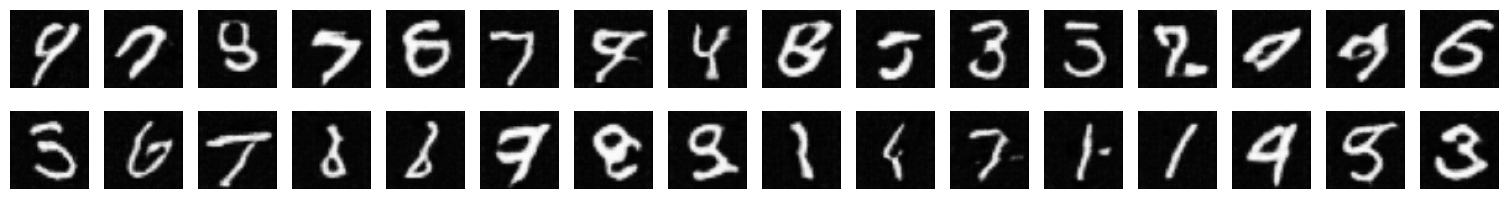

[7/10][250/469]	Loss_D: 0.1120	Loss_G: 3.1845	D(x): 0.9183	D(G(z)): 0.0206 / 0.0605
[7/10][300/469]	Loss_D: 0.0570	Loss_G: 4.5026	D(x): 0.9766	D(G(z)): 0.0320 / 0.0161
[7/10][350/469]	Loss_D: 0.2935	Loss_G: 2.8862	D(x): 0.8684	D(G(z)): 0.1263 / 0.0793
[7/10][400/469]	Loss_D: 0.2926	Loss_G: 3.4753	D(x): 0.9681	D(G(z)): 0.2063 / 0.0451
[7/10][450/469]	Loss_D: 0.0809	Loss_G: 4.0837	D(x): 0.9329	D(G(z)): 0.0088 / 0.0260
[8/10][0/469]	Loss_D: 1.3016	Loss_G: 0.3735	D(x): 0.4212	D(G(z)): 0.1936 / 0.7425
[8/10][50/469]	Loss_D: 0.1920	Loss_G: 4.3607	D(x): 0.8549	D(G(z)): 0.0200 / 0.0211
[8/10][100/469]	Loss_D: 1.0256	Loss_G: 4.2332	D(x): 0.9746	D(G(z)): 0.5820 / 0.0215
[8/10][150/469]	Loss_D: 0.6614	Loss_G: 2.0638	D(x): 0.7026	D(G(z)): 0.2119 / 0.1715
[8/10][200/469]	Loss_D: 0.1459	Loss_G: 3.4410	D(x): 0.9597	D(G(z)): 0.0940 / 0.0466


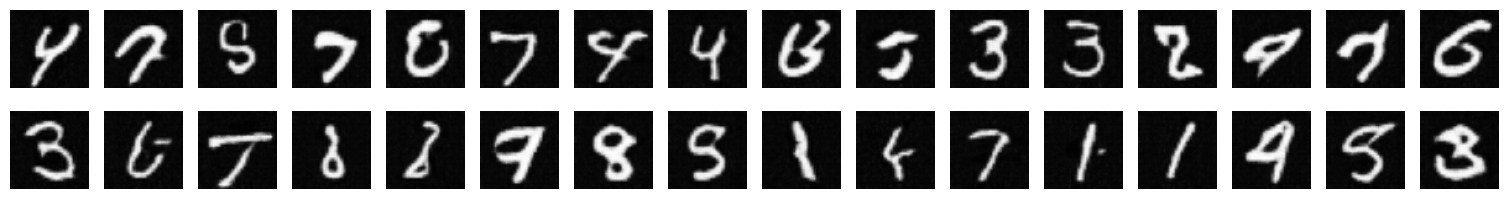

[8/10][250/469]	Loss_D: 0.0462	Loss_G: 4.4874	D(x): 0.9717	D(G(z)): 0.0169 / 0.0160
[8/10][300/469]	Loss_D: 0.4884	Loss_G: 2.5830	D(x): 0.8264	D(G(z)): 0.2318 / 0.0970
[8/10][350/469]	Loss_D: 0.1211	Loss_G: 3.1850	D(x): 0.9229	D(G(z)): 0.0365 / 0.0577
[8/10][400/469]	Loss_D: 0.8407	Loss_G: 2.4505	D(x): 0.7916	D(G(z)): 0.3998 / 0.1121
[8/10][450/469]	Loss_D: 0.1840	Loss_G: 3.2366	D(x): 0.9324	D(G(z)): 0.0990 / 0.0572
[9/10][0/469]	Loss_D: 0.4895	Loss_G: 2.8712	D(x): 0.7951	D(G(z)): 0.2007 / 0.0767
[9/10][50/469]	Loss_D: 0.0873	Loss_G: 3.7056	D(x): 0.9741	D(G(z)): 0.0575 / 0.0350
[9/10][100/469]	Loss_D: 0.5554	Loss_G: 2.3178	D(x): 0.7363	D(G(z)): 0.1869 / 0.1310
[9/10][150/469]	Loss_D: 0.3719	Loss_G: 3.6340	D(x): 0.8902	D(G(z)): 0.1977 / 0.0395
[9/10][200/469]	Loss_D: 0.7386	Loss_G: 1.8282	D(x): 0.6585	D(G(z)): 0.2050 / 0.2106
[9/10][250/469]	Loss_D: 0.1798	Loss_G: 3.6779	D(x): 0.9270	D(G(z)): 0.0902 / 0.0367


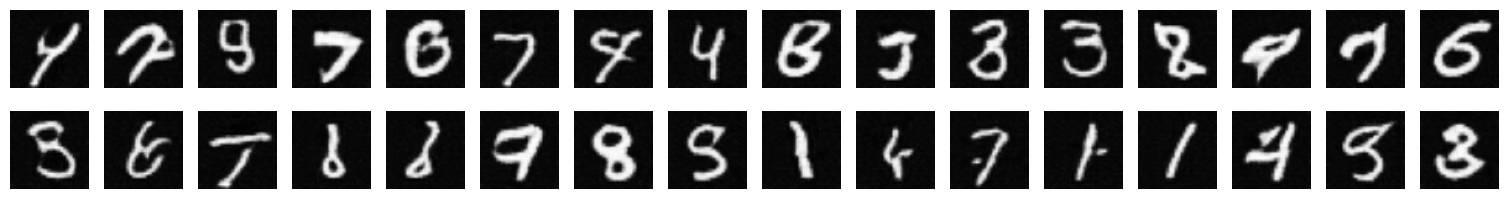

[9/10][300/469]	Loss_D: 0.0978	Loss_G: 4.1880	D(x): 0.9175	D(G(z)): 0.0085 / 0.0239
[9/10][350/469]	Loss_D: 0.1190	Loss_G: 3.5247	D(x): 0.9431	D(G(z)): 0.0554 / 0.0419
[9/10][400/469]	Loss_D: 0.5349	Loss_G: 2.9579	D(x): 0.8166	D(G(z)): 0.2504 / 0.0725
[9/10][450/469]	Loss_D: 0.2097	Loss_G: 3.9880	D(x): 0.8865	D(G(z)): 0.0724 / 0.0274


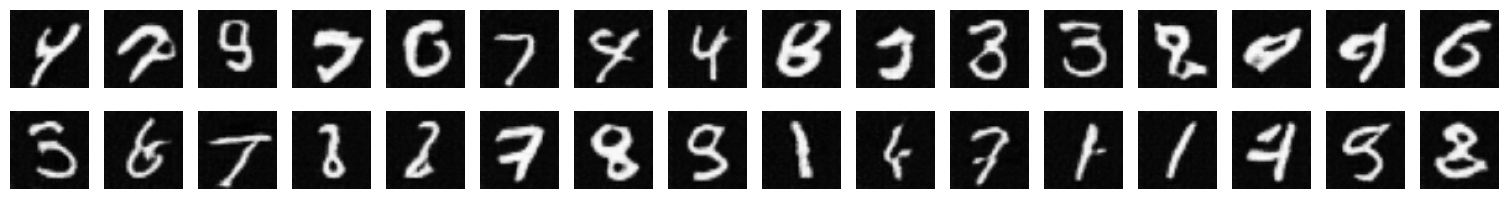

In [42]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()


        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()

            fake_batch = fake[:32].reshape(-1, X_DIM, X_DIM, 1)
            plot_images(fake_batch, vmin=-1, vmax=1, columns=16, height=1.2, width=1.2)

        iters += 1

real images


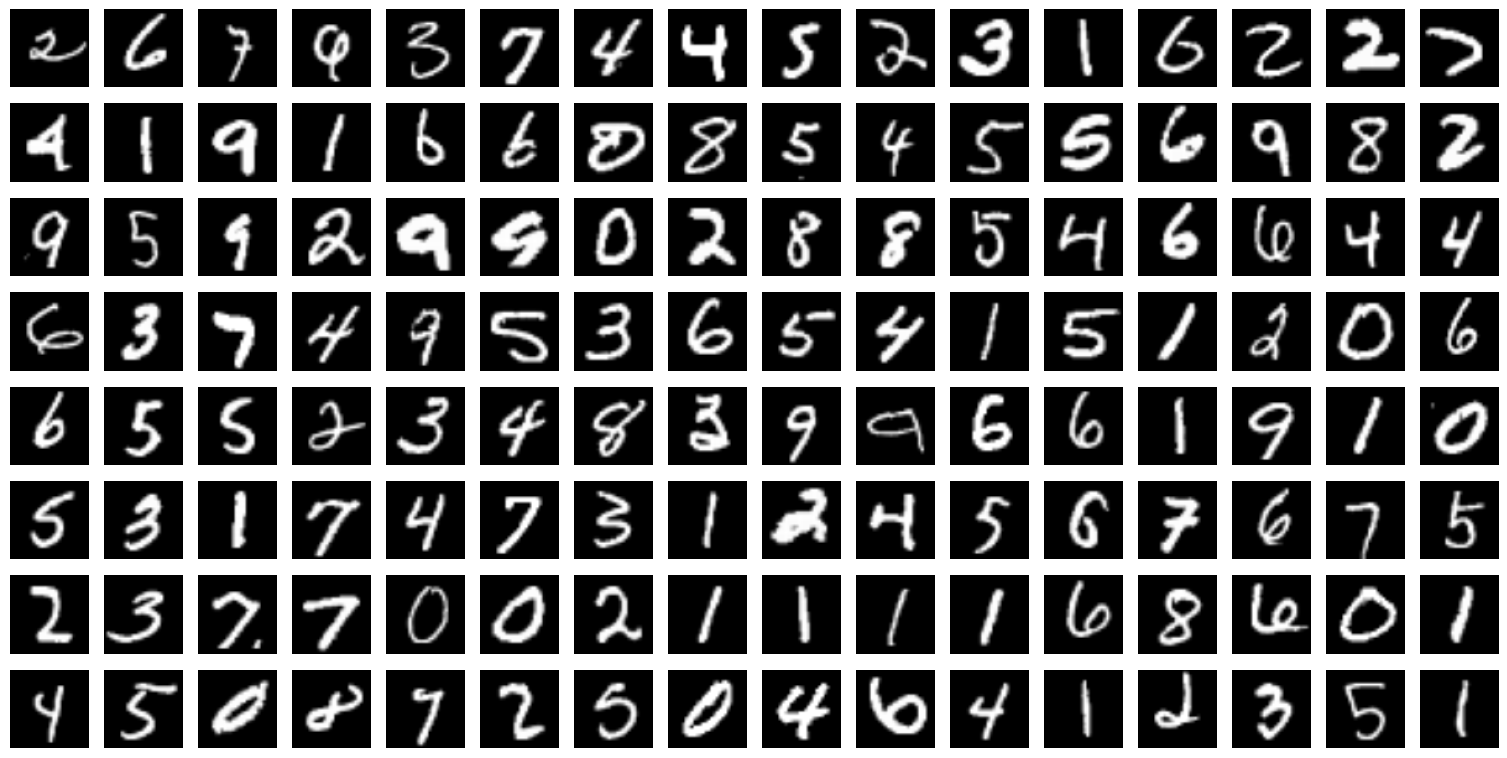

In [43]:
next_real_batch = next(iter(dataloader))
real_batch = next_real_batch[0].reshape(-1, X_DIM, X_DIM, 1)
print("real images")
plot_images(real_batch, vmin=-1, vmax=1, columns=16, height=1.2, width=1.2)

fake images


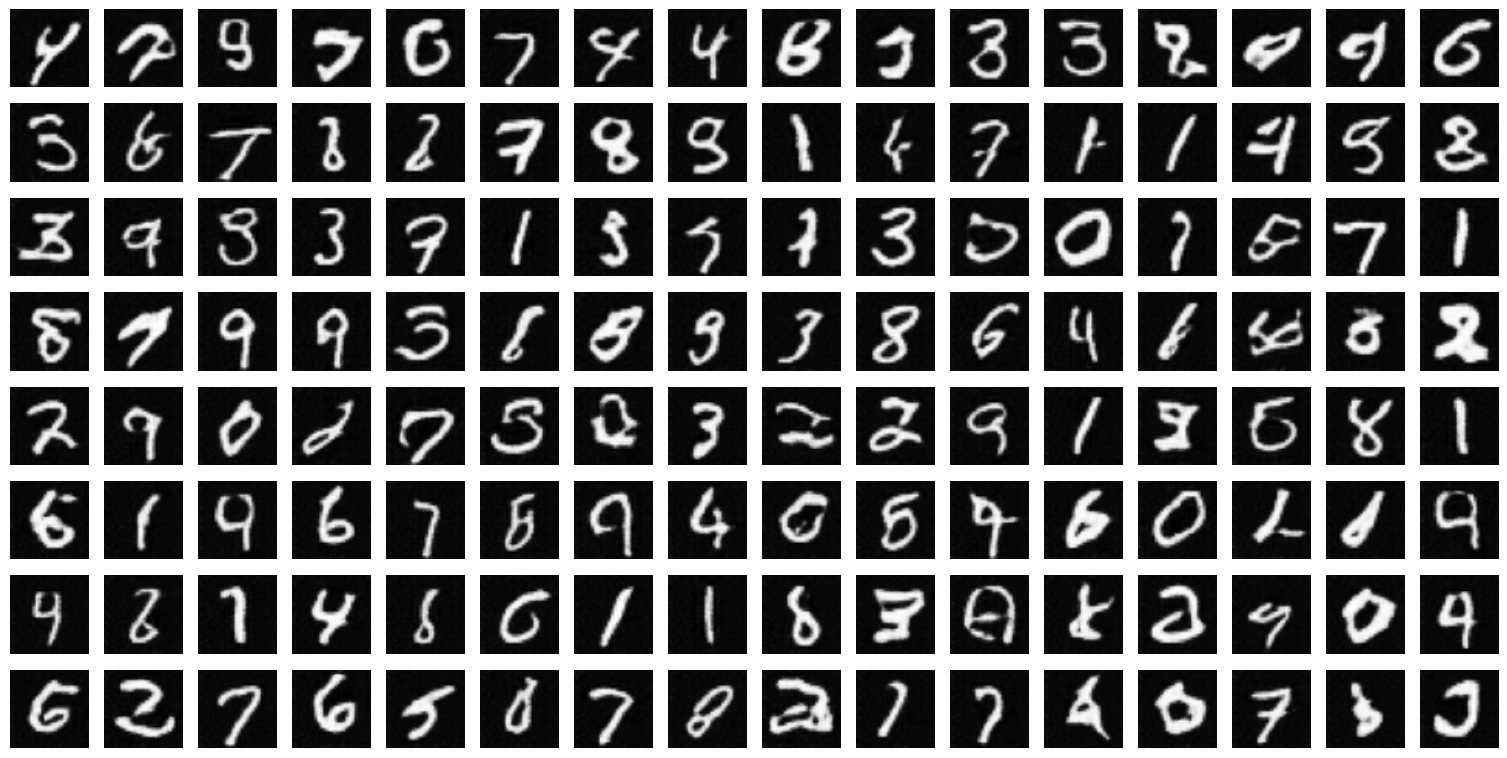

In [44]:
with torch.no_grad():
    fake = netG(viz_noise).detach().cpu()

print("fake images")
fake_batch = fake.reshape(-1, X_DIM, X_DIM, 1)
plot_images(fake_batch, vmin=-1, vmax=1, columns=16, height=1.2, width=1.2)

In [45]:
import torch.onnx

# Export the model
dummy_input = torch.randn(1, Z_DIM, 1, 1).to(device)  # Latent space input (a dummy one, so that ONNX knows the shapes)
torch.onnx.export(
    netG,
    dummy_input,
    "Models/GAN.onnx",
    input_names=["latent_vector"],
    output_names=["generated_image"],
    dynamic_axes={"latent_vector": {0: "batch_size"}, "generated_image": {0: "batch_size"}},
    opset_version=11
)